In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [3]:
os.chdir(os.path.dirname(working_dir))

In [4]:
working_dir = os.getcwd()
print(f"You have now changed your working directory to {working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [5]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

<hr>

### Search for non-image files


In [ ]:
"""
This function will search through the raw dataset
for files that doesn´t have the extensions
that we typed in at 'image_extension'.

When going through all the files the arrays for
image_files and non_image_files are filled with
result that in the end will be printed out.    
"""


def search_non_image_files(raw_dir):
    
    image_extension = ('.png', '.jpg', '.jpeg') # file extensions to search for
    
    non_image_files = [] # array for files without the extension searched for
    image_files = [] # array for image files with the extension searched for
    
    folders = os.listdir(raw_dir)
    for folder in folders:
        files = os.listdir(os.path.join(raw_dir, folder))
        
        for file in files: 
            file_location = os.path.join(raw_dir, folder, file)
            if not file.lower().endswith(image_extension):
                non_image_files.append(file_location)
            else:
                image_files.append(file_location)
    

    print("Total amount of folders searched:", len(folders))
    print("Total image files found:", len(image_files))
    print("Total non image files found:", len(non_image_files))
    
    return image_files, non_image_files

In [ ]:
search_non_image_files(raw_dir='inputs/dataset/raw/flower_photos')

<hr>

### Find names on the flower categories

In [ ]:
def names_of_the_flowers(folders):
    
    
    flowers = []
    for directory in os.listdir(folders):
        directory_path = os.path.join(folders, directory)
        if os.path.isdir(directory_path):
            flowers.append(directory)
            
    
    print("These are the flowers in the dataset:")
    for flower in flowers:
        print(flower)
    
    return flowers



In [ ]:
folders = 'inputs/dataset/raw/flower_photos'

flowers = names_of_the_flowers(folders)
print("Amount of flowers:", len(flowers))  

# Save flowers as a .pkl-file
file_path = 'outputs/v1'  
joblib.dump(value=flowers, filename=f"{file_path}/flowers.pkl")

<hr>

### Image distribution

In [11]:
def images_distribution(image_dirs, save_path=None):

    # Creates a list that collects images per flower category
    images_per_flower = {}
    for flowers in os.listdir(image_dirs):
        flowers_path = os.path.join(image_dirs, flowers)
        if os.path.isdir(flowers_path):
            images_per_flower[flowers] = len([img for img in os.listdir(flowers_path) if img.endswith(('.png', 'jpg', 'jpeg'))])
            

    # Convert this list to a dataframe
    df = pd.DataFrame(list(images_per_flower.items()), columns=['Flowers', 'Count'])

    # Calculate the percentage of images per flower
    df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

    # Calculate the highest, the lowest and mean value of the distribution
    highest_perc = df.loc[df['Percentage'].idxmax()]
    lowest_perc = df.loc[df['Percentage'].idxmin()]
    mean_percentage = df['Percentage'].mean()
    mean_count = df['Count'].mean()
    


    # Create a barplot to visualize this distibution of images per flower
    plt.figure(figsize=(15, 8))
    bars = plt.bar(df['Flowers'], df['Percentage'], color='skyblue')
    plt.axhline(y=mean_percentage, color='r', linestyle='--')
    plt.xlabel('Flowers')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution of images per flower')
    plt.xticks(rotation=90)

    # Adds extra text to the top of the barplot
    plt.gcf().text(0.45, 0.85, f"Mean percentage: {mean_percentage:.2f}% ({mean_count:.0f} images)", fontsize=10)
    plt.gcf().text(0.45, 0.82, f"Highest percentage: {highest_perc['Flowers']} - {highest_perc['Percentage']:.2f}%", fontsize=10)
    plt.gcf().text(0.45, 0.79, f"Lowest percentage: {lowest_perc['Flowers']} - {lowest_perc['Percentage']:.2f}%", fontsize=10)

    # Adds extra text over each bar to show amount of images
    for bar, count in zip(bars, df['Count']):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.3,  
            f'{count}',  
            ha='center', va='bottom', fontsize=9, color='black'
            )
    
    # If save_path is given it will save an image of the barplot at the given path
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
    
    # Shows the barplot
    plt.tight_layout()
    plt.show()
    
    return df

In [ ]:
all_flowers = images_distribution(image_dirs = 'inputs/dataset/raw/flower_photos', save_path=f'outputs/{version}/raw_image_distribution.png')




<hr>

### Resize images

In [ ]:
from matplotlib.image import imread
"""
This loop goes through all the flower
folders and opens up all the images
and collection shape height and width
into 2 arrays. 
    
A scatterplot then visualising the mean
value of the image shapes
"""

image_dir = 'inputs/dataset/raw/flower_photos'
folders = os.listdir(image_dir)

dim1, dim2 = [], []
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):
        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            try:
                img = imread(image_path)
                d1, d2, colors = img.shape
                dim1.append(d1) # image height
                dim2.append(d2) # image width
            except Exception as e:
                print(f"Error when trying to open: {image_path}. \n")
                print(f"Error message: {e}")


# Creates a scatterplot with the image sizes        
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim2_mean, color='r', linestyle='--')
axes.axhline(y=dim1_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [ ]:
mean_image_shape = (dim1_mean, dim2_mean, 3)
mean_image_shape

joblib.dump(value=mean_image_shape,
            filename=f"{file_path}/mean_image_shape.pkl")

#### Resizing

In [6]:
from PIL import Image

# Defines the new image shape
image_shape = (224, 224)

# Image folders and output folders
image_dir = 'inputs/dataset/raw'
output_dir = 'inputs/dataset/resized_250x250'

# Creates the outputfolder if it doesn´t exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loops through all sub-directories for images
for root, dirs, files in os.walk(image_dir):
    # Creates sub-directories for resized images
    relative_path = os.path.relpath(root, image_dir)
    save_dir = os.path.join(output_dir, relative_path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for image_file in files:
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, image_file)
            img = Image.open(img_path)
            img_resized = img.resize(image_shape)
            
            # Saves copies of the resized images
            resized_img_path = os.path.join(save_dir, image_file)
            img_resized.save(resized_img_path)

print(f"All images have been resized to {image_shape} and saved in {output_dir}")

All images have been resized to (224, 224) and saved in inputs/dataset/resized_250x250


### Split into train/validation/test sets

In [8]:
import shutil
import random


def split_train_validation_test_images(image_dir, train_set_ratio, validation_set_ratio, test_set_ratio):
    
    # Check if the ratios are set to the correct total amount
    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print("The total of train_set_ratio, validation_set_ratio and test_set_ratio should be 1.0")
        return

    flowers = os.listdir(image_dir)
    
    # Creates train, validation and test folders if they don´t exist
    for folder in ['train', 'validation', 'test']:
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        for flower in flowers:
            flower_folder_path = os.path.join(folder_path, flower)
            os.makedirs(flower_folder_path, exist_ok=True)

    # Moves images to the right sub-folder
    for flower in flowers:
        files = os.listdir(os.path.join(image_dir, flower))
        random.shuffle(files)

        train_set_files_qty = int(len(files) * train_set_ratio)
        validation_set_files_qty = int(len(files) * validation_set_ratio)

        count = 1
        for image_name in files:
            src_path = os.path.join(image_dir, flower, image_name)
            if count <= train_set_files_qty:
                dest_path = os.path.join(image_dir, 'train', flower, image_name)
            elif count <= (train_set_files_qty + validation_set_files_qty):
                dest_path = os.path.join(image_dir, 'validation', flower, image_name)
            else:
                dest_path = os.path.join(image_dir, 'test', flower, image_name)
            
            shutil.move(src_path, dest_path)
            count += 1

        # Deletes the inputfolder if it´s empty
        os.rmdir(os.path.join(image_dir, flower))

In [9]:
split_train_validation_test_images(image_dir=f"inputs/dataset/raw/flower_photos",
                                   train_set_ratio=0.7,
                                   validation_set_ratio=0.1,
                                   test_set_ratio=0.2
                                   )

Test distribution



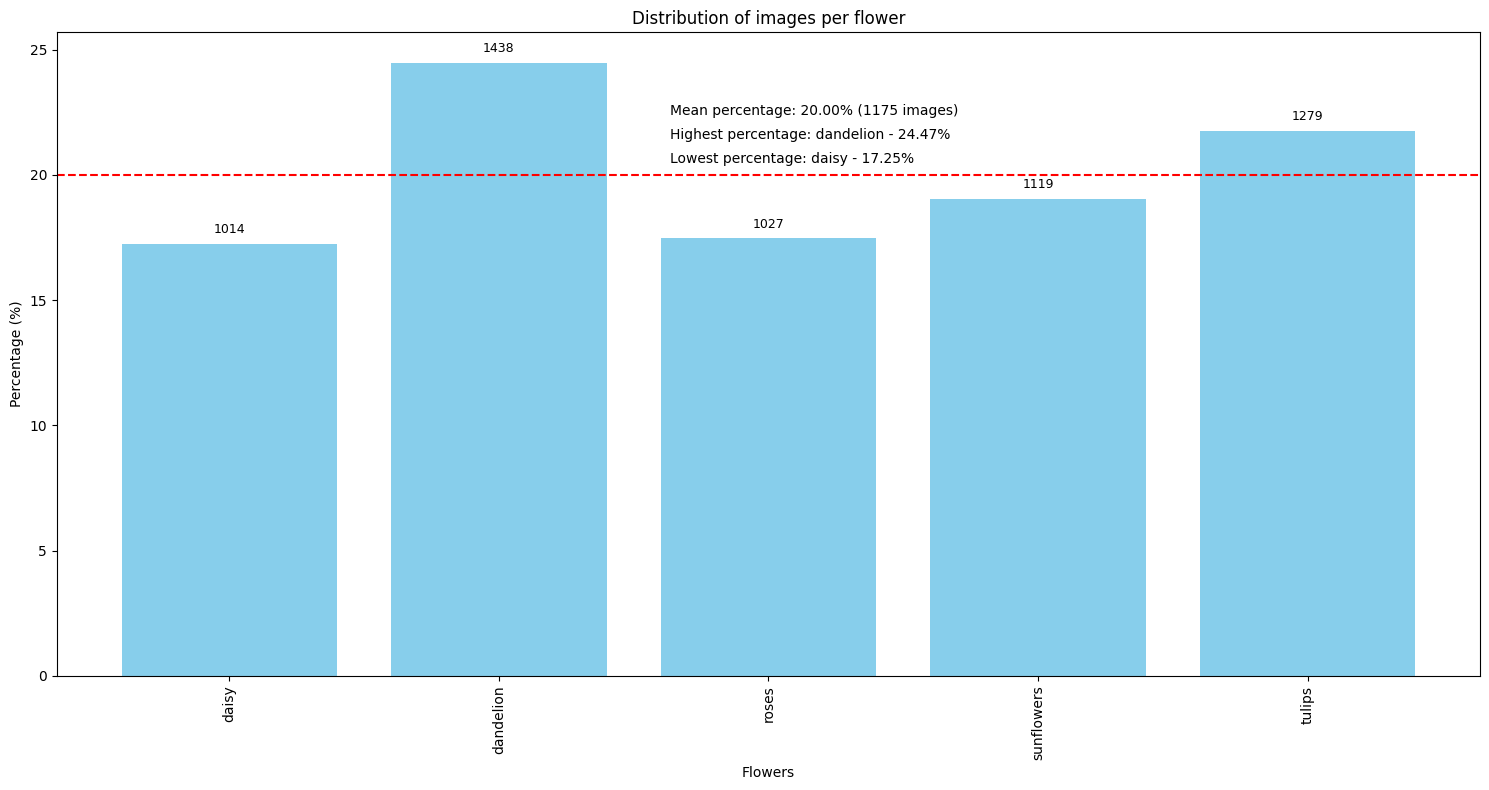


 Validation distribution



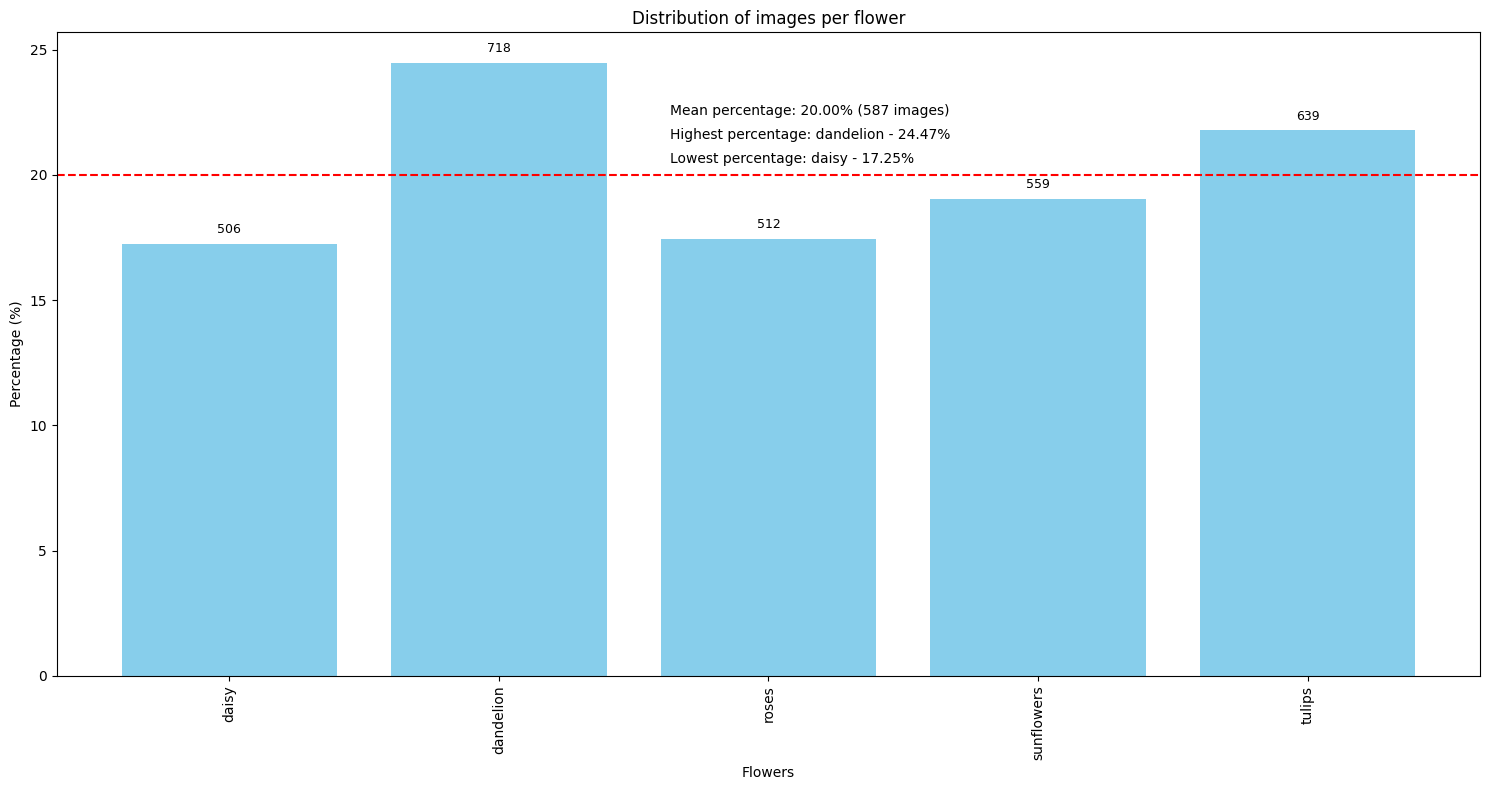


 Train distribution



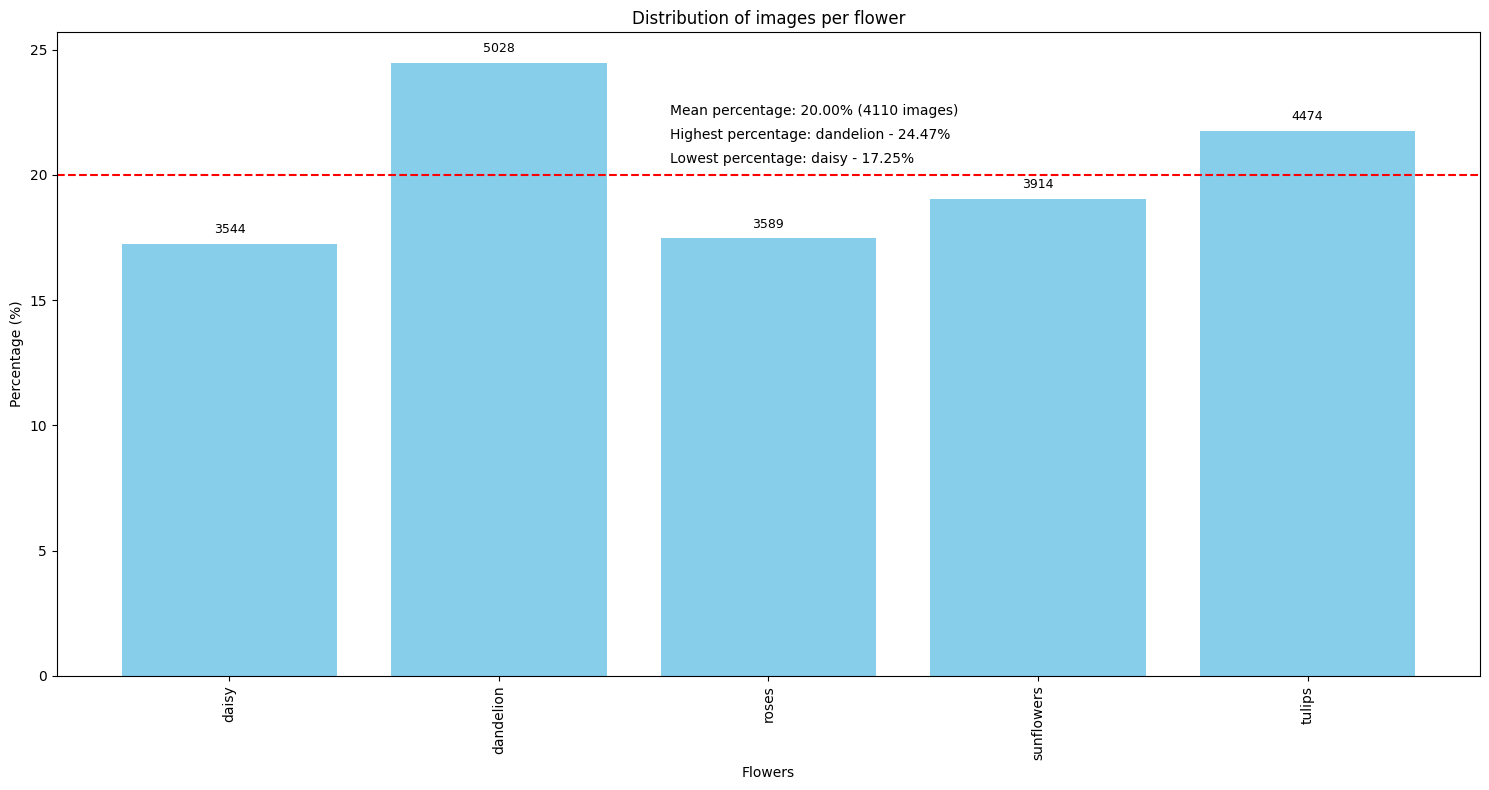

,Flowers,Count,Percentage
0,daisy,3544,17.246581
1,dandelion,5028,24.468344
2,roses,3589,17.465570
3,sunflowers,3914,19.047156
4,tulips,4474,21.772349


In [12]:

print("Test distribution\n")
images_distribution(image_dirs='inputs/dataset/raw/flower_photos/test', save_path=f'outputs/{version}/test_set_distribution.png')

print("\n Validation distribution\n")
images_distribution(image_dirs='inputs/dataset/raw/flower_photos/validation', save_path=f'outputs/{version}/validation_set_distribution.png')

print("\n Train distribution\n")
images_distribution(image_dirs='inputs/dataset/raw/flower_photos/train', save_path=f'outputs/{version}/train_set_distribution.png')